In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import codecs
import re

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

## 資料準備 : 詳細介紹可參考NLP第一階段課程Day20,21

In [4]:
all_data=[]
paths =[r'spam_data/spam_data/spam', r'spam_data/spam_data/easy_ham', r'spam_data/spam_data/hard_ham'] 
for path in paths:
    for fn in glob.glob(path+"/*"):
        if "ham" not in fn:
            is_spam = 1
        else:
            is_spam = 0
        #codecs.open可以避開錯誤，用errors='ignore'
        with codecs.open(fn,encoding='utf-8', errors='ignore') as file:
            for line in file:
                #這個line的開頭為Subject:
                if line.startswith("Subject:"):
                    subject=re.sub(r"^Subject:","",line).strip()
                    all_data.append([subject,is_spam])
all_data = np.array(all_data)

In [5]:
X = all_data[:,0]
Y = all_data[:,1].astype(np.uint8)

In [6]:
X[:10]

array(['Life Insurance - Why Pay More?',
       '[ILUG] Guaranteed to lose 10-12 lbs in 30 days 10.206',
       'Guaranteed to lose 10-12 lbs in 30 days                          11.150',
       'Re: Fw: User Name & Password to Membership To 5 Sites zzzz@example.com pviqg',
       '[ILUG-Social] re: Guaranteed to lose 10-12 lbs in 30 days 10.148',
       'RE: Your Bank Account Information',
       'FORTUNE 500 COMPANY HIRING, AT HOME REPS.',
       'Is Your Family Protected?',
       'RE: Important Information Concerning Your Bank Account',
       'MULTIPLY YOUR CUSTOMER BASE!'], dtype='<U109')

In [7]:
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords

import nltk

nltk.download('stopwords')

# Lemmatize with POS Tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 

## 創建Lemmatizer
lemmatizer = WordNetLemmatizer() 
def get_wordnet_pos(word):
    """將pos_tag結果mapping到lemmatizer中pos的格式"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def clean_content(X):
    # remove non-alphabet characters
    X_clean = [re.sub('[^a-zA-Z]',' ', x).lower() for x in X]
    # tokenize
    X_word_tokenize = [nltk.word_tokenize(x) for x in X_clean]
    # stopwords_lemmatizer
    X_stopwords_lemmatizer = []
    stop_words = set(stopwords.words('english'))
    for content in X_word_tokenize:
        content_clean = []
        for word in content:
            if word not in stop_words:
                word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
                content_clean.append(word)
        X_stopwords_lemmatizer.append(content_clean)
    
    X_output = [' '.join(x) for x in X_stopwords_lemmatizer]
    
    return X_output
                 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
X = clean_content(X)

In [9]:
X[:10]

['life insurance pay',
 'ilug guaranteed lose lb day',
 'guaranteed lose lb day',
 'fw user name password membership site zzzz example com pviqg',
 'ilug social guaranteed lose lb day',
 'bank account information',
 'fortune company hire home rep',
 'family protect',
 'important information concern bank account',
 'multiply customer base']

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
#max_features是要建造幾個column，會按造字出現的頻率高低去篩選，1500並沒有特別含義，大家可以自己嘗試不同數值或不加入限制
cv=CountVectorizer(max_features = 1500)
X=cv.fit_transform(X).toarray()

In [12]:
from sklearn.model_selection import train_test_split
# random_state是為了讓各為學員得到相同的結果，平時可以移除
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [13]:
x_train.shape

(2738, 1500)

In [14]:
np.unique(y_train)

array([0, 1], dtype=uint8)

### 判斷是否有GPU可以使用

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### 模型搭建

In [17]:
class LinearBNAC(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True, dropout=0.3, is_output=False):
        super(LinearBNAC, self).__init__()
        if is_output:
            self.linear = nn.Linear(in_channels, out_channels, bias=bias)
        else:
            self.linear = nn.Sequential(
                nn.Linear(in_channels, out_channels, bias=bias),
                nn.BatchNorm1d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.Dropout(dropout),
            )
            
    def forward(self, x):
        out=self.linear(x)
        return out

In [18]:
class Model(nn.Module):
    def __init__(self, input_dimention, output_classes=1):
        super(Model, self).__init__()
        self.layer1 = LinearBNAC(input_dimention, 16)
        self.layer2 = LinearBNAC(16, 32)
        self.output = LinearBNAC(32, output_classes, is_output=True)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.output(x)
        return x  
        

### 建立模型

* to(device) 代表轉成 cpu or gpu 模式 (gpu 模式下稱為 cuda)

In [19]:
model = Model(input_dimention=1500,output_classes=2).to(device)

In [20]:
for name,_ in model.named_parameters():
    print(name, _.shape)

layer1.linear.0.weight torch.Size([16, 1500])
layer1.linear.0.bias torch.Size([16])
layer1.linear.1.weight torch.Size([16])
layer1.linear.1.bias torch.Size([16])
layer2.linear.0.weight torch.Size([32, 16])
layer2.linear.0.bias torch.Size([32])
layer2.linear.1.weight torch.Size([32])
layer2.linear.1.bias torch.Size([32])
output.linear.weight torch.Size([2, 32])
output.linear.bias torch.Size([2])


In [21]:
batch_size = 4
input_features = 1500
dummy_input = torch.randn(batch_size, input_features).to(device)


In [22]:
output = model(dummy_input)
print(output)

tensor([[ 0.3329, -0.5495],
        [ 0.1085,  0.0390],
        [-0.2180, -0.2491],
        [ 0.2172,  0.8049]], device='cuda:0', grad_fn=<AddmmBackward>)


## Loss

#### classification

In [23]:
from torch.nn import NLLLoss, LogSoftmax, CrossEntropyLoss

In [24]:
## CrossEntropyLoss = LogSoftmax + NLLLoss

* CrossEntropyLoss

In [25]:
criterion = CrossEntropyLoss()

## optimizer

In [26]:
import torch.optim as optim

* params : iterable of parameters
* lr : learning rate
* weight_decay : (L2) Regularization (正則化) 

In [27]:
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)

### 訓練前準備

In [28]:
x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
x_test = torch.tensor(x_test, dtype=torch.float32).to(device)

y_train_numpy = y_train.copy()
y_test_numpy = y_test.copy()

y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

In [29]:
batch_size = 4
epochs = 50
softmax = nn.Softmax(-1)

index = np.array([x for x in range(len(x_train))])

### 訓練

In [30]:
train_loss_ = []
test_loss_ = []
train_accuracy_ = []
test_accuracy_ = []
for epoch in range(epochs):
    
    np.random.shuffle(index)
    x_train = x_train[index]
    y_train = y_train[index]

    loss_keeper = []
    model.train()
    
    for batch in range(len(x_train)//batch_size):
        x = x_train[batch*batch_size : (batch+1)*batch_size,:]
        y = y_train[batch*batch_size : (batch+1)*batch_size]
        output = model(x)
        loss_train = criterion(output, y)
        '自行填入'
        '自行填入'
        '自行填入'
        loss_train.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train = loss_train.detach().cpu().item()
        loss_keeper.append(loss_train)    
    
    model.eval()
    output = model(x_test)
    prediction = softmax(output)
    prediction = torch.argmax(prediction,1).detach().cpu().numpy()
    test_accuracy = metrics.accuracy_score(prediction, y_test_numpy)
    loss_test = criterion(output, y_test)
    loss_test = loss_test.detach().cpu().item()
    train_loss_.append(np.mean(loss_keeper))
    test_loss_.append(loss_test)
    
    if epoch % 2 == 0:
        print('epoch : {}'.format(epoch))
        print('目前 train loss : {:.2f}'.format(np.mean(loss_keeper)))
        print('目前 test loss : {:.2f}'.format(loss_test))
        print('目前 test accuracy : {:.2f}'.format(test_accuracy))


epoch : 0
目前 train loss : 0.45
目前 test loss : 0.38
目前 test accuracy : 0.86
epoch : 2
目前 train loss : 0.32
目前 test loss : 0.36
目前 test accuracy : 0.88
epoch : 4
目前 train loss : 0.27
目前 test loss : 0.30
目前 test accuracy : 0.90
epoch : 6
目前 train loss : 0.24
目前 test loss : 0.27
目前 test accuracy : 0.91
epoch : 8
目前 train loss : 0.23
目前 test loss : 0.26
目前 test accuracy : 0.92
epoch : 10
目前 train loss : 0.22
目前 test loss : 0.27
目前 test accuracy : 0.89
epoch : 12
目前 train loss : 0.19
目前 test loss : 0.26
目前 test accuracy : 0.91
epoch : 14
目前 train loss : 0.21
目前 test loss : 0.24
目前 test accuracy : 0.92
epoch : 16
目前 train loss : 0.18
目前 test loss : 0.29
目前 test accuracy : 0.90
epoch : 18
目前 train loss : 0.19
目前 test loss : 0.30
目前 test accuracy : 0.90
epoch : 20
目前 train loss : 0.19
目前 test loss : 0.29
目前 test accuracy : 0.90
epoch : 22
目前 train loss : 0.17
目前 test loss : 0.30
目前 test accuracy : 0.89
epoch : 24
目前 train loss : 0.17
目前 test loss : 0.29
目前 test accuracy : 0.90
epoch : 26
目前 tra

In [31]:
print(classification_report(prediction,y_test_numpy))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       570
           1       0.71      0.61      0.66       115

    accuracy                           0.89       685
   macro avg       0.82      0.78      0.80       685
weighted avg       0.89      0.89      0.89       685



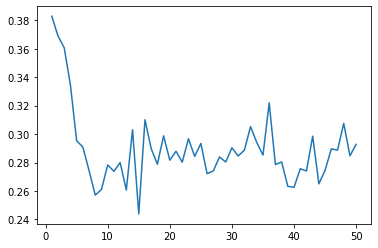

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(test_loss_)+1), test_loss_)
plt.show()

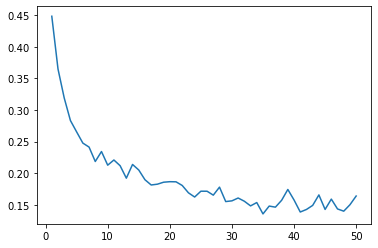

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.arange(1, len(train_loss_)+1), train_loss_)
plt.show()

---

### 儲存跟載入 weight

### 儲存

In [34]:
##假設我們已經訓練好了模型
## 可以存成 .pth or .pt
saving_location = './model_save.pth' # './' 代表目前所屬路徑
torch.save(model.state_dict(), f=saving_location)

### 載入 

In [36]:
model = Model(input_dimention=1500,output_classes=2).to(device)

##載入
checkpoint = torch.load(saving_location, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
print('loading successfully...')
print('\n')

model.eval()

test_content = ['Congratulations! You Get a Free Handheld Organizer!']
test_content = clean_content(test_content)
test_content = cv.transform(test_content).toarray()
test_content = torch.tensor(test_content, dtype=torch.float32).to(device)
output = model(test_content)
prediction = softmax(output)
prediction = torch.argmax(prediction,1).detach().cpu().numpy()[0]

if prediction == 1:
    print('Is spam')
else:
    print('Not spam')

loading successfully...


Is spam
